# QRR Implementation

In [1]:
eye_candy_opts = {
    'node_size': 1200,  # Twice the default size of 600
    'node_color': '#4287f5',  # A nice blue color
    'font_color': 'white',
    'edge_color': 'grey',
    'with_labels': True,
    'font_weight': 'bold',
}

# I.  QAOA for Maxcut



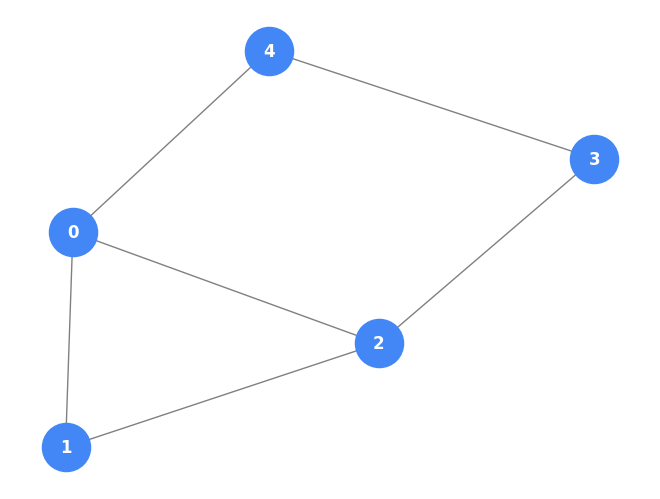

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
pos =draw_graph(graph, **eye_candy_opts)

## 1.1 Hamiltonian and Ansatz


### a.Hamiltonian

In [3]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### b. Ansatz

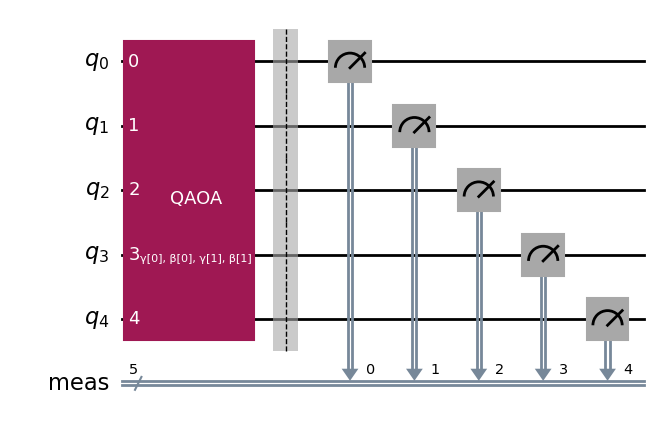

In [4]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [5]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### c. "Hardware"

In [6]:
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


device_backend = FakeVigoV2()
backend =  AerSimulator.from_backend(device_backend)

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="11189973089719193ddb5044d62a265e24ed2b6e3e47091e59882e3a2d77588214b57a158cacd867c018000d658ff5410d3d83ef71581369d72e50ca89e7b59a", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum')
print(backend)


AerSimulator('aer_simulator_from(fake_vigo)'
             noise_model=<NoiseModel on ['measure', 'x', 'id', 'cx', 'sx']>)


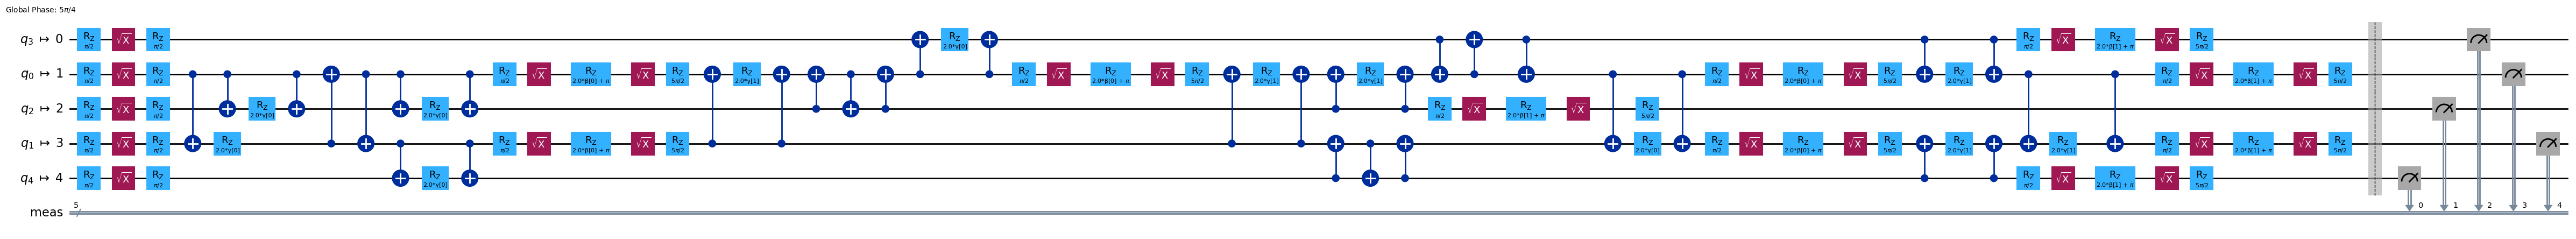

In [7]:

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

# II. Classical Optimization of the parameters

In [8]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [9]:
objective_func_vals = []


def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [10]:
from qiskit_aer.primitives import EstimatorV2 as Estimator
# from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize



# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
# estimator = Estimator.from_backend(backend)
# estimator.options.default_shots = 1000


estimator = Estimator()

# # Set simple error suppression/mitigation options
# estimator.options.dynamical_decoupling.enable = True
# estimator.options.dynamical_decoupling.sequence_type = "XY4"
# estimator.options.twirling.enable_gates = True
# estimator.options.twirling.num_randomizations = "auto"

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.037109375
       x: [ 4.373e+00  2.821e+00  3.573e+00  1.492e+00]
    nfev: 31
   maxcv: 0.0


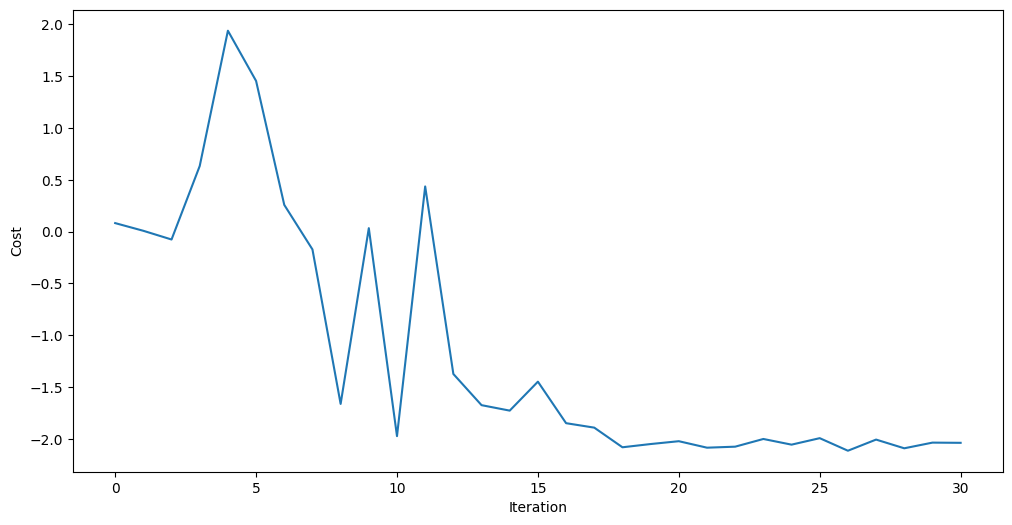

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

# III.Run the optimized circuit with the Samplers


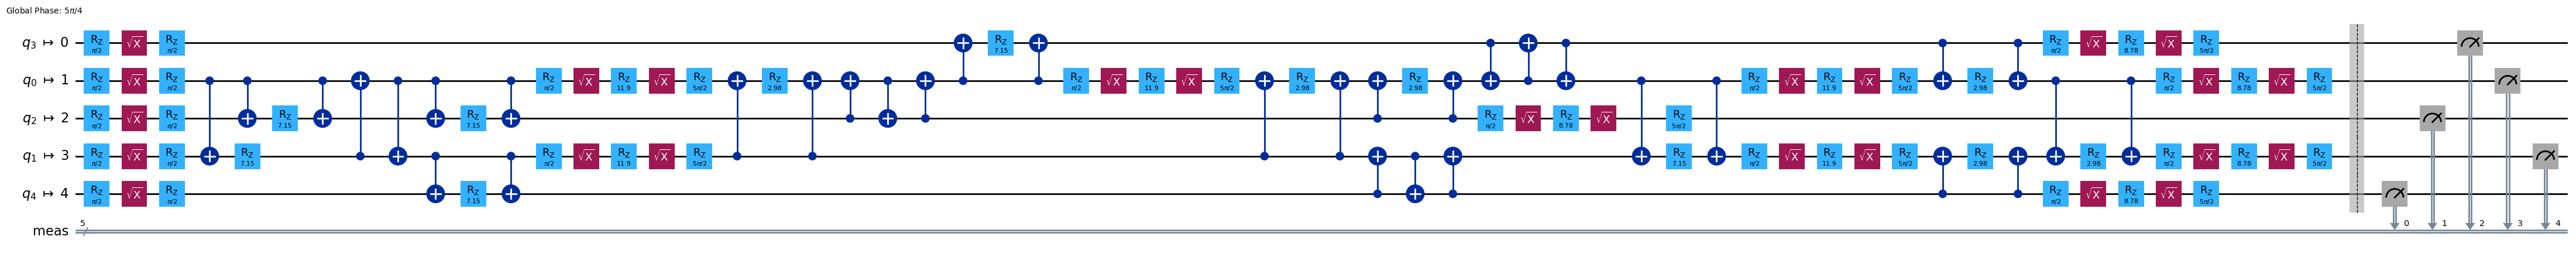

In [12]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [13]:
type(optimized_circuit) # for convienience, we can look up the doc of the class to see what methods are available

qiskit.circuit.quantumcircuit.QuantumCircuit

### Look at the distribution of multiple shots
<font color='red'>
Quantum Stuff are done here now
</font>

In [14]:
# from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
# sampler = Sampler.from_backend(backend)
# sampler.options.default_shots = 10000

sampler = Sampler(default_shots=10000)


pub= (optimized_circuit, )
job = sampler.run([pub])
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_bin)

{'01010': 0.0459, '11010': 0.1625, '10011': 0.0184, '01001': 0.0743, '01011': 0.0745, '10100': 0.0736, '01101': 0.0449, '00101': 0.1555, '10101': 0.043, '10110': 0.07, '11110': 0.0124, '10010': 0.0451, '01100': 0.0206, '01000': 0.0045, '00001': 0.0116, '11001': 0.0087, '00010': 0.0142, '01110': 0.0188, '11011': 0.0109, '10001': 0.0194, '00100': 0.014, '11111': 0.0007, '11100': 0.0075, '00011': 0.0069, '11101': 0.0173, '01111': 0.0027, '10111': 0.003, '10000': 0.0034, '00110': 0.0075, '00111': 0.0036, '11000': 0.0042, '00000': 0.0004}


In [15]:
print(final_distribution_bin)

{'01010': 0.0459, '11010': 0.1625, '10011': 0.0184, '01001': 0.0743, '01011': 0.0745, '10100': 0.0736, '01101': 0.0449, '00101': 0.1555, '10101': 0.043, '10110': 0.07, '11110': 0.0124, '10010': 0.0451, '01100': 0.0206, '01000': 0.0045, '00001': 0.0116, '11001': 0.0087, '00010': 0.0142, '01110': 0.0188, '11011': 0.0109, '10001': 0.0194, '00100': 0.014, '11111': 0.0007, '11100': 0.0075, '00011': 0.0069, '11101': 0.0173, '01111': 0.0027, '10111': 0.003, '10000': 0.0034, '00110': 0.0075, '00111': 0.0036, '11000': 0.0042, '00000': 0.0004}



<div style="background-color: #007bff; height: 5px;"></div>

# V. Post-Processing: ⭐️ Q Relax and Round  ⭐️

<div style="background-color: #007bff; height: 5px;"></div>





1. Expectation value calculation
   1. the optimal state from the measurement?
   2. figure out what `Estimator` is doing and what `Sampler` is doing 

In [16]:
def _corr_base(counts, n_qubits):
    correlation_matrix = np.zeros((n_qubits, n_qubits))
    for bitstring, prob in counts.items():
        state = [int(bit) for bit in bitstring]
        for i in range(n_qubits):
            for j in range(i, n_qubits):
                zi = 1 - 2 * state[i]  # Convert 0/1 to +1/-1
                zj = 1 - 2 * state[j]
                correlation_matrix[i, j] += ((i==j) - 1) * prob * zi * zj
                if i != j:
                    correlation_matrix[j, i] = correlation_matrix[i, j]
    return correlation_matrix


def correlation_matrix_sampler(optimized_circuit, n_qubits, shots=10000):
    sampler = Sampler(default_shots=shots)
    pub= (optimized_circuit, )
    job = sampler.run([pub])
    counts_bin = job.result()[0].data.meas.get_counts()
    final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
    return _corr_base(final_distribution_bin, n_qubits)
    
    

def calculate_correlation_matrix_with_estimator(circuit, n_qubits):
    raise NotImplementedError

In [17]:
correlation_matrix = correlation_matrix_sampler(optimized_circuit, n)

In [18]:
correlation_matrix

array([[ 0.    ,  0.1622,  0.0324, -0.2674,  0.505 ],
       [ 0.1622,  0.    ,  0.5182, -0.2776,  0.034 ],
       [ 0.0324,  0.5182,  0.    ,  0.4994, -0.0826],
       [-0.2674, -0.2776,  0.4994,  0.    ,  0.4988],
       [ 0.505 ,  0.034 , -0.0826,  0.4988,  0.    ]])

Eigenvalues:
[ 0.70230674  0.47571348  0.45214878 -0.53346618 -1.09670283]

Eigenvectors:
[[ 0.24936555  0.25886796  0.53624736  0.55593925  0.52361676]
 [ 0.42639653  0.66948924  0.18643818 -0.56538568 -0.12469962]
 [ 0.57923509 -0.25321426 -0.52227434 -0.156638    0.55051185]
 [ 0.56419477 -0.55270022  0.42605531  0.0088205  -0.44114147]
 [ 0.31964635  0.33937669 -0.47263723  0.58877612 -0.46109262]]


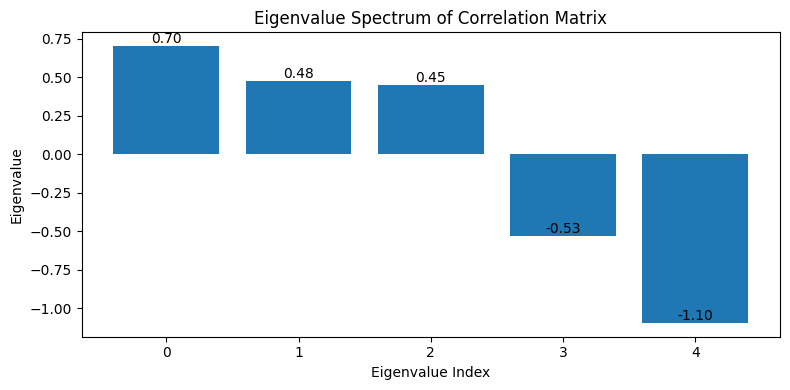

In [19]:
# Perform eigen decomposition of the correlation matrix
eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)

# Sort eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx].T

print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

# Visualize the eigenvalue spectrum with a smaller plot and annotated values
plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(eigenvalues)), eigenvalues)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Spectrum of Correlation Matrix')

# Annotate each bar with its value
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()



In [20]:
eigenvectors[0]

array([0.24936555, 0.25886796, 0.53624736, 0.55593925, 0.52361676])

In [21]:
solution_candidates = np.sign(eigenvectors)

In [22]:
solution_candidates[0]

array([1., 1., 1., 1., 1.])

<div style="background-color: #007bff; padding: 10px; border-radius: 5px; text-align: center;">
     <p style="color: white; font-family:Georgia, serif; margin: 0;">⭐️ End: Relax and Round  ⭐️</p>
</div>


In [23]:
def calculate_max_cut_cost_pm1(solution, edge_list):
    cost = 0
    for edge in edge_list:
        u, v, weight = edge
        cost += weight * (1 - solution[u] * solution[v]) / 2
    return cost

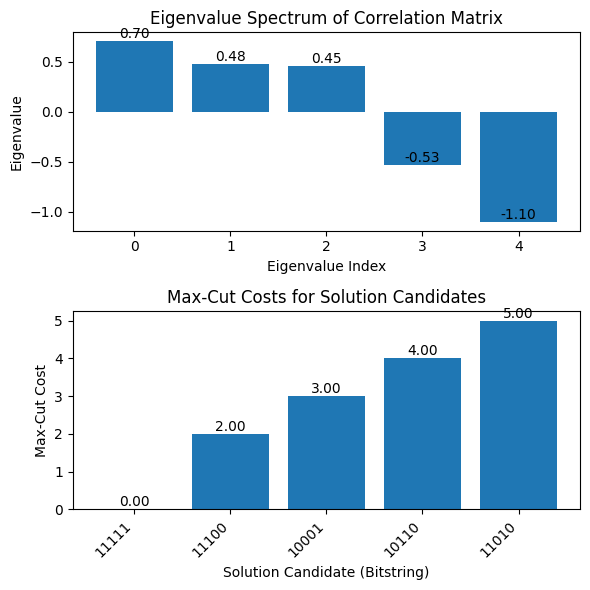


Best solution: [ 1.  1. -1.  1. -1.]
Best bitstring: 11010
Best max-cut cost: 5.0


In [24]:
# Calculate max_cut cost for each solution candidate
max_cut_costs = []
for solution in solution_candidates:
    cost = calculate_max_cut_cost_pm1(solution, edge_list)
    max_cut_costs.append(cost)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Plot eigenvalues
ax1.bar(range(len(eigenvalues)), eigenvalues)
ax1.set_xlabel('Eigenvalue Index')
ax1.set_ylabel('Eigenvalue')
ax1.set_title('Eigenvalue Spectrum of Correlation Matrix')

# Annotate each bar with its value
for i, v in enumerate(eigenvalues):
    ax1.text(i, v, f'{v:.2f}', ha='center', va='bottom', rotation=0)

# Plot max-cut costs
x = range(len(max_cut_costs))
ax2.bar(x, max_cut_costs)
ax2.set_ylabel('Max-Cut Cost')
ax2.set_title('Max-Cut Costs for Solution Candidates')

# Create x-axis labels with bitstrings
bitstrings = [''.join(map(str, ((solution + 1) // 2).astype(int))) for solution in solution_candidates]
ax2.set_xticks(x)
ax2.set_xticklabels(bitstrings, rotation=45, ha='right')
ax2.set_xlabel('Solution Candidate (Bitstring)')

# Annotate each bar with its value
for i, v in enumerate(max_cut_costs):
    ax2.text(i, v, f'{v:.2f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Find and print the best solution
best_solution_index = np.argmax(max_cut_costs)
best_solution = solution_candidates[best_solution_index]
best_cost = max_cut_costs[best_solution_index]
best_bitstring = bitstrings[best_solution_index]

print(f"\nBest solution: {best_solution}")
print(f"Best bitstring: {best_bitstring}")
print(f"Best max-cut cost: {best_cost}")




In [25]:
import networkx as nx
from utils.visualization import visualize_max_cut


ModuleNotFoundError: No module named 'utils'

Number of cut edges: 5
Total weight of cut edges: 5.00
Max-cut value: 5.00


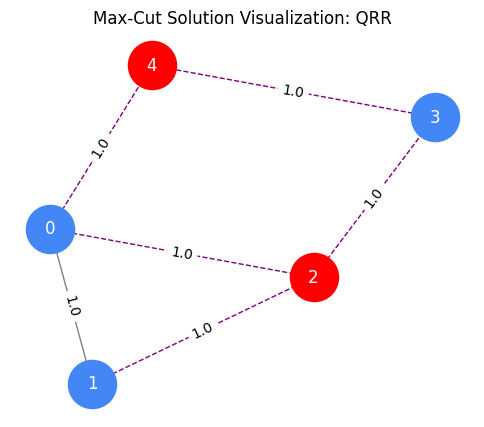

In [26]:

# Visualize the best solution
pos = visualize_max_cut(best_solution, edge_list, pos, eye_candy_opts, title="QRR")

# Print the number of cut edges and the total weight of the cut
cut_edges = [(u, v, w) for (u, v, w) in edge_list if best_solution[u] != best_solution[v]]
cut_edges_count = len(cut_edges)
cut_weight = sum(w for _, _, w in cut_edges)

print(f"Number of cut edges: {cut_edges_count}")
print(f"Total weight of cut edges: {cut_weight:.2f}")
print(f"Max-cut value: {best_cost:.2f}")


# IV. Post-processing: QAOA


In [27]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

def to_solution(bitstring):
    # Convert bitstring to numpy array and map 0 to -1, 1 stays 1
    return np.array([-1 if bit == 0 else 1 for bit in bitstring])

def from_solution(solution):
    # Convert solution back to bitstring, mapping -1 to 0 and 1 to 1
    return [0 if bit == -1 else 1 for bit in solution]

keys = list(final_distribution_int.keys())
values = list(final_distribution_bin.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()
most_likely_solution = to_solution(most_likely_bitstring)

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 1]


In [28]:
best_bitstring = ''.join([str(bit) for bit in from_solution(best_solution)])

In [29]:
best_bitstring

'00101'

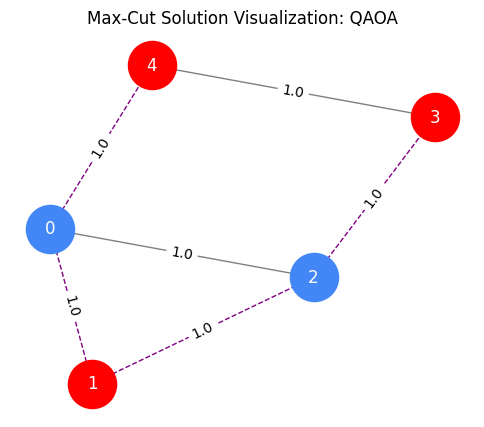

In [30]:
pos = visualize_max_cut(most_likely_solution, edge_list, pos, eye_candy_opts, title="QAOA")

In [31]:
final_distribution_bin

{'10110': 0.0893,
 '01010': 0.0479,
 '11010': 0.1198,
 '00001': 0.011,
 '01001': 0.0885,
 '01100': 0.0264,
 '10101': 0.0481,
 '01011': 0.0937,
 '00101': 0.1165,
 '10100': 0.0903,
 '00011': 0.0083,
 '00100': 0.0098,
 '00111': 0.0027,
 '00010': 0.0107,
 '10010': 0.0465,
 '01101': 0.0461,
 '10011': 0.0258,
 '10001': 0.0274,
 '01111': 0.0007,
 '01110': 0.0256,
 '11101': 0.0112,
 '11110': 0.0098,
 '11011': 0.0126,
 '11001': 0.0084,
 '11000': 0.0026,
 '01000': 0.0002,
 '00110': 0.01,
 '11100': 0.0084,
 '00000': 0.0006,
 '10111': 0.0003,
 '11111': 0.0005,
 '10000': 0.0003}

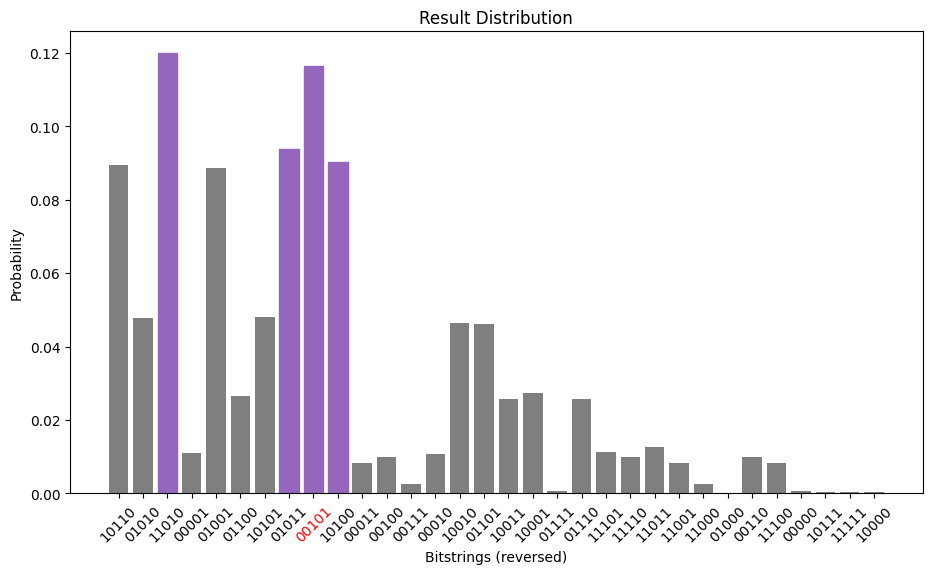

In [32]:
%load_ext autoreload
%autoreload 2

from utils.visualization import plot_result_distribution
plot_result_distribution(final_distribution_bin, best_bitstring)

In [33]:
import numpy as np

def Z_i(n, i):
    """
    Returns the Pauli Z operator on the i-th qubit.
    """
    return np.kron(np.eye(2**(i-1)), np.kron(np.array([[1, 0], [0, -1]]), np.eye(2**(n-i))))


def Z_ij(n, i, j):
    """
    Returns the tensor product of Pauli Z operators on the i-th and j-th qubits.
    """
    return Z_i(n, i) @  Z_i(n, j)


    

In [34]:
Z_i(3, 2)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -0.,  0.,  0., -0., -0.],
       [ 0.,  0., -0., -1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -0., -0.,  0.,  0., -1., -0.],
       [ 0.,  0., -0., -0.,  0.,  0., -0., -1.]])

In [35]:
Z_ij(3, 1, 2) + Z_ij(3, 2, 1) + Z_ij(3, 2, 3) + Z_ij(3, 3, 2) + Z_ij(3, 1, 3) + Z_ij(3, 3, 1)

array([[ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]])


<div style="background-color: #007bff; height: 5px;"></div>

# VI. ⭐️ GW Algorithm (Classical) ⭐️

<div style="background-color: #007bff; height: 5px;"></div>





W:
 [[0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]]
Cut: [ 1. -1.  1.  1. -1.]
Cut value: 4.0
Optimal u: [-0.93793197  1.41934162 -0.93265197  0.23110766  0.22013465]


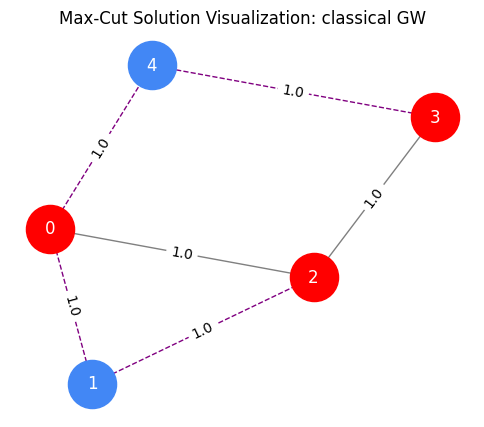

In [40]:
import numpy as np
import networkx as nx
import sys
from scipy.optimize import minimize


def goemans_williamson_maxcut_with_correction(edgelist, W=None):
    # Create graph from weighted edgelist
    G = nx.Graph()
    G.add_weighted_edges_from(edgelist)
    n = G.number_of_nodes()
    
    # Create D and W matrices
    D = np.diag([G.degree(node, weight='weight') for node in G.nodes()])
    if W is None:
        W = nx.adjacency_matrix(G, weight='weight').toarray()
    print(f"W:\n {W}")

    def objective(u):
        # Define the inner maximization problem
        def inner_objective(z):
            return -0.25 * z.T @ (D - W + np.diag(u)) @ z

        # Solve the inner maximization problem
        constraints = {'type': 'eq', 'fun': lambda z: np.sum(z**2) - 1}
        result = minimize(inner_objective, np.random.randn(n), constraints=constraints, tol=1e-10)
        return -result.fun  # Return the negative because we're minimizing

    # Solve the outer minimization problem
    constraints = {'type': 'eq', 'fun': lambda u: np.sum(u)}
    result = minimize(objective, np.zeros(n), constraints=constraints)

    u_opt = result.x
    
    # Solve the final maximization problem with optimal u
    def final_objective(z):
        return -0.25 * z.T @ (D - W + np.diag(u_opt)) @ z

    constraints = {'type': 'eq', 'fun': lambda z: np.sum(z**2) - 1}
    result = minimize(final_objective, np.random.randn(n), constraints=constraints, tol=1e-10)
    z_opt = result.x

    # Perform random hyperplane rounding
    cut = np.sign(z_opt)
    
    # Compute the weighted cut value
    cut_value = 0
    for i, j, weight in G.edges(data='weight'):
        if cut[i] != cut[j]:
            cut_value += weight
    
    return cut, cut_value, u_opt

# Example usage
cut, cut_value, u_opt = goemans_williamson_maxcut_with_correction(edge_list)

print(f"Cut: {cut}")
print(f"Cut value: {cut_value}")
print(f"Optimal u: {u_opt}")
visualize_max_cut(cut, edge_list, pos, eye_candy_opts, title="classical GW");


<div style="background-color: #007bff; height: 5px;"></div>

# VI. ⭐️ GW Algorithm (RnR Correlation) ⭐️

<div style="background-color: #007bff; height: 5px;"></div>

In [41]:
correlation_matrix

array([[ 0.    ,  0.307 , -0.0268, -0.2212,  0.4804],
       [ 0.307 ,  0.    ,  0.4682, -0.2194, -0.0202],
       [-0.0268,  0.4682,  0.    ,  0.482 ,  0.05  ],
       [-0.2212, -0.2194,  0.482 ,  0.    ,  0.4448],
       [ 0.4804, -0.0202,  0.05  ,  0.4448,  0.    ]])

W:
 [[ 0.      0.307  -0.0268 -0.2212  0.4804]
 [ 0.307   0.      0.4682 -0.2194 -0.0202]
 [-0.0268  0.4682  0.      0.482   0.05  ]
 [-0.2212 -0.2194  0.482   0.      0.4448]
 [ 0.4804 -0.0202  0.05    0.4448  0.    ]]
Cut: [-1. -1.  1. -1.  1.]
Cut value: 5.0
Optimal u: [-0.45840127  0.61458117 -0.69356128  0.12519581  0.41218557]


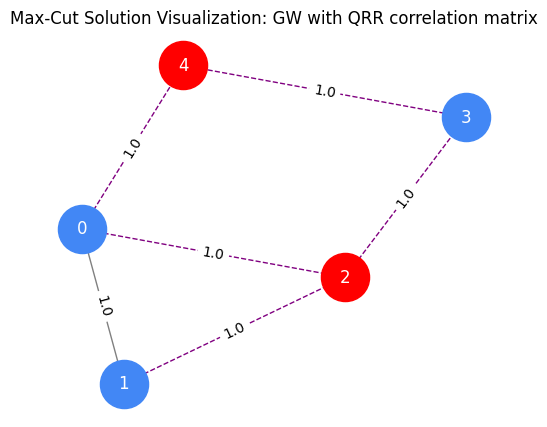

In [43]:

cut, cut_value, u_opt = goemans_williamson_maxcut_with_correction(edge_list, W=correlation_matrix)

print(f"Cut: {cut}")
print(f"Cut value: {cut_value}")
print(f"Optimal u: {u_opt}")
visualize_max_cut(cut, edge_list, pos, eye_candy_opts, title="GW with QRR correlation matrix");